In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pizza-sales:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2566526%2F4363377%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240901%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240901T041308Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D88b20661e6e8621acdb412d44e40f4853a97f1bf8d825ad3a5e7d736fab5fa70f9cf6540f0a0ff1a82ae3b7bbbbb2e89d6cf654f216f78f6c7391fa3bdaaf4296dfbd56156fb2bc6308dde1050976a842cfc38de156ff659b01e14ffde1c01dad6f3cc7327206739454409f9f2503c5413a274e62d427031bd32b391a8dcf0033bcdb7bbaecaf7fb22a72403f6cdc2122d05d0b7c2533d64583ab87f9d002a1a1de7a92198677126c5d2fef0a87ed4669d9ea1c1b7f16d00b9ea11c09c2db352fca19f8ec3b70ab94b3ee6aa0f22b07b67f475d9a9551c4e5982485a84181b2643e171cba85f8ab4de58a274502e0a0a23b4aace9edba0a353607e1755e8432e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4329148 bytes downloaded
Downloaded and uncompressed: pizza-sales
Data source import complete.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.graph_objs as go
import plotly.express as px

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pizza-sales/Data Model - Pizza Sales.xlsx


In [3]:
# Load the data
data = pd.read_excel("/kaggle/input/pizza-sales/Data Model - Pizza Sales.xlsx")
data.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


# Fields and Data Types 📊:
The dataset includes the following attributes:

- **order_id:** Unique identifier for each order placed by a table
- **order_details_id:** Unique identifier for each pizza placed within each order (pizzas of the same type and size are kept in the same row, and the quantity increases)
- **pizza_id:** Unique key identifier that ties the pizza ordered to its details, like size and price
- **quantity:** Quantity ordered for each pizza of the same type and size
- **order_date:** Date the order was placed (entered into the system prior to cooking & serving)
- **order_time:** Time the order was placed (entered into the system prior to cooking & serving)
- **unit_price:** Price of the pizza in USD
- **total_price:** unit_price * quantity
- **pizza_size:** Size of the pizza (Small, Medium, Large, X Large, or XX Large)
- **pizza_type:** Unique key identifier that ties the pizza ordered to its details, like size and price
- **pizza_ingredients:** ingredients used in the pizza as shown in the menu (they all include Mozzarella Cheese, even if not specified; and they all include Tomato Sauce, unless another sauce is specified)
- **pizza_name:** Name of the pizza as shown in the menu

In [4]:
# Display information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_details_id   48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_id           48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 4.5+ MB
None


In [5]:
# Descriptive statistics
data.describe()

,order_details_id,order_id,quantity,order_date,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620,48620.000000,48620.000000
mean,24310.500000,10701.479761,1.019622,2015-06-29 11:03:43.611682560,16.494132,16.821474
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,2015-03-31 00:00:00,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,2015-06-28 00:00:00,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,2015-09-28 00:00:00,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000
std,14035.529381,6180.119770,0.143077,NaN,3.621789,4.437398


In [6]:
# Display column names
data.columns

Index(['order_details_id', 'order_id', 'pizza_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name'],
      dtype='object')

# Handling missing data

In [7]:
# Verify the data
print(data.isnull().sum())

order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64


# EDA (Exploratory Data Analysis)

<ipython-input-8-ce838dfc590b>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax, data=data, x=feature, palette=color_palette)
<ipython-input-8-ce838dfc590b>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=10)
<ipython-input-8-ce838dfc590b>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax, data=data, x=feature, palette=color_palette)
<ipython-input-8-ce838dfc590b>:40: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.countplot(ax=ax, data=data, x=feature, palette=color_palette)
<ipython-input-8-ce838dfc590b>:43: UserW

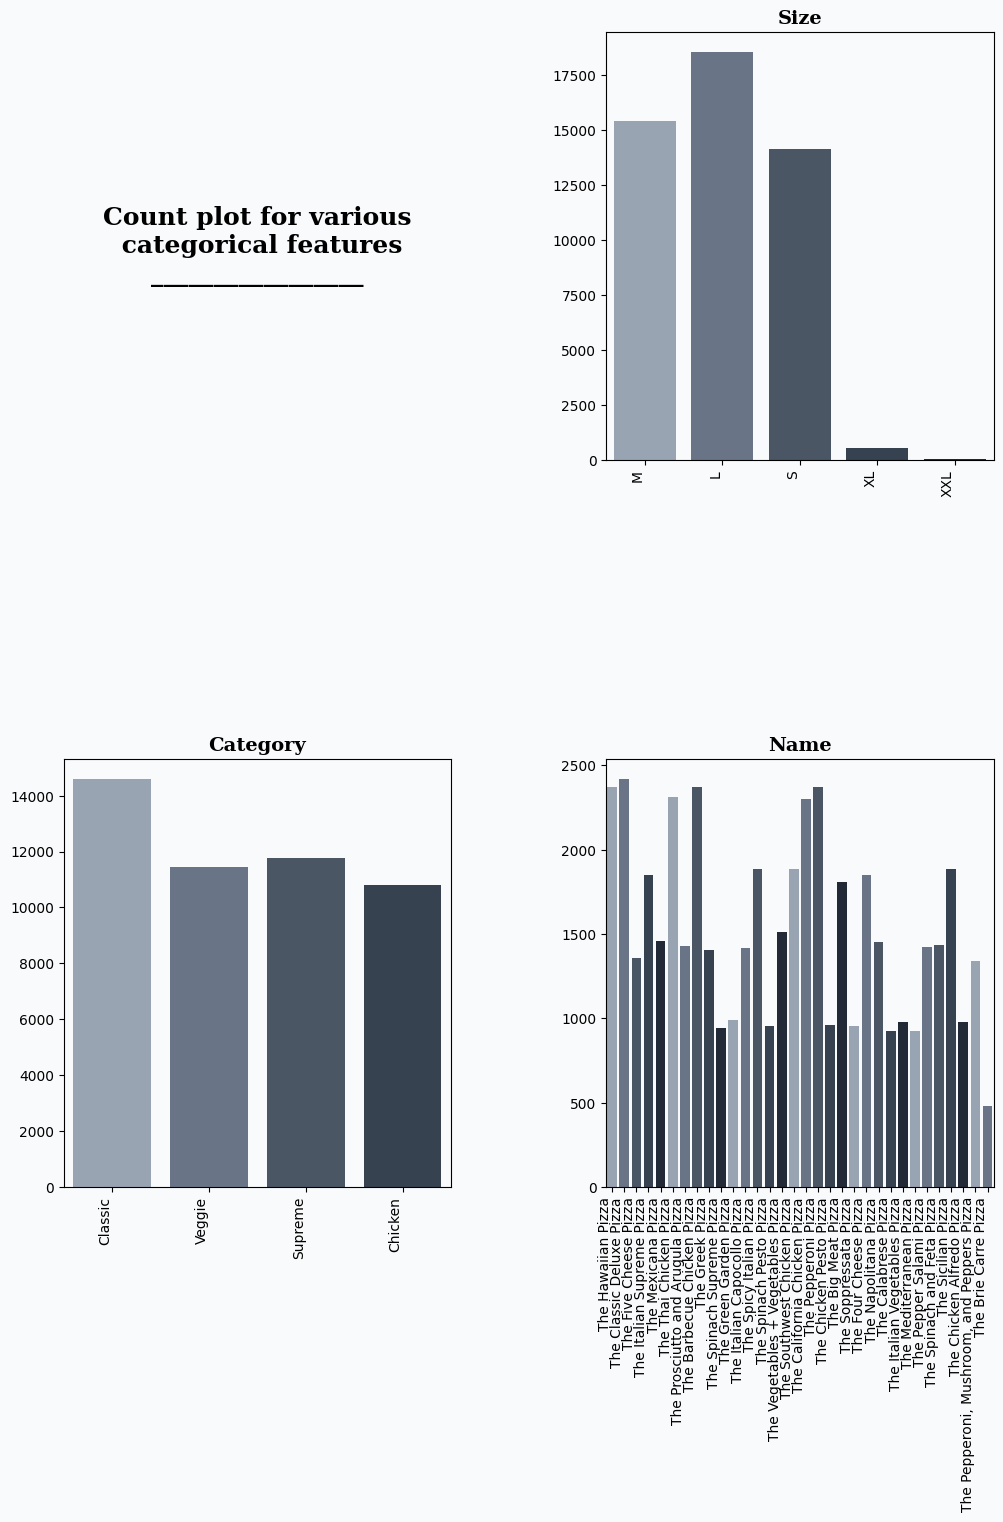

In [8]:
# Figure adjustments

# Larger size for better visualization
fig = plt.figure(figsize=(12, 15))
gs = fig.add_gridspec(2, 2)
# Increases space between subplots
gs.update(wspace=0.4, hspace=0.7)


background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]
fig.patch.set_facecolor(background_color)
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(2)]
for ax in axes:
    ax.set_facecolor(background_color)

# Title of the plot
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Count plot for various\n categorical features\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

# Plot for each categorical feature
plot_features = ['pizza_size', 'pizza_category', 'pizza_name']
titles = ["Size", "Category", "Name"]

for i, feature in enumerate(plot_features):
    ax = axes[i + 1]
    ax.set_title(titles[i], loc='center', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
    sns.countplot(ax=ax, data=data, x=feature, palette=color_palette)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=10)

# Adjust and show
plt.show()

In [9]:
data['order_time']=data['order_time'].astype('string')
data[['Hour','Minute', 'Second']]= data['order_time'].str.split(":",expand=True)
data["Hour"].value_counts()

,count
Hour,
12,6543
13,6203
18,5359
17,5143
19,4350
16,4185
14,3521
20,3487
15,3170


<ipython-input-10-c01c876e6fb9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x="Hour",palette="ocean")


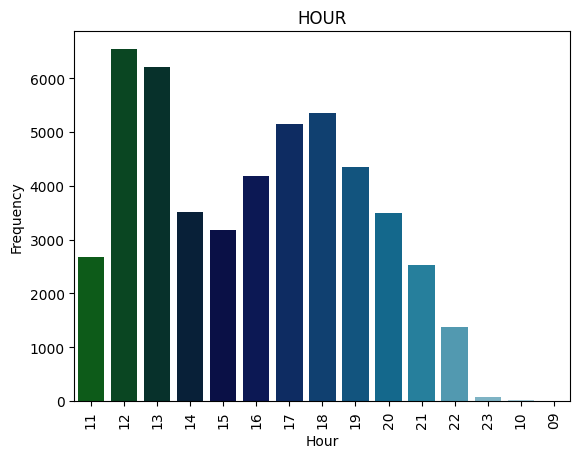

In [10]:
sns.countplot(data=data,x="Hour",palette="ocean")
plt.xticks(rotation=90)
plt.xlabel("Hour",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("HOUR")
plt.show()

In [11]:
data['order_year'] =pd.DatetimeIndex( data['order_date']).year
data['order_year'].value_counts()

,count
order_year,
2015,48620


In [12]:
data['order_dates'] = data['order_date'].dt.day_name()
data['order_dates'].value_counts()

,count
order_dates,
Friday,8106
Saturday,7355
Thursday,7323
Wednesday,6797
Tuesday,6753
Monday,6369
Sunday,5917


<ipython-input-13-c20e7fb7f1d3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x="order_dates",palette="ocean")


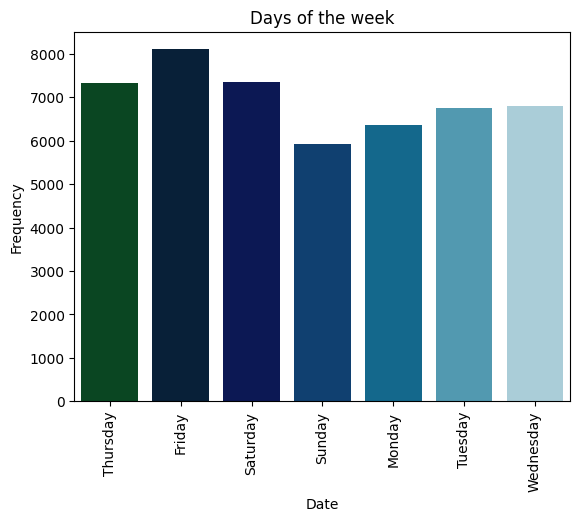

In [13]:
# Days of the week
sns.countplot(data=data,x="order_dates",palette="ocean")
plt.xticks(rotation=90)
plt.xlabel("Date",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Days of the week")
plt.show()

In [14]:
data['order_month'] =pd.DatetimeIndex (data['order_date']).month
data.loc[(data['order_month'] ==1), 'order_month'] = 'January'
data.loc[(data['order_month'] ==2), 'order_month'] = 'February'
data.loc[(data['order_month'] ==3), 'order_month'] = 'March'
data.loc[(data['order_month'] ==4), 'order_month'] = 'April'
data.loc[(data['order_month'] ==5), 'order_month'] = 'May'
data.loc[(data['order_month'] ==6), 'order_month'] = 'June'
data.loc[(data['order_month'] ==7), 'order_month'] = 'July'
data.loc[(data['order_month'] ==8), 'order_month'] = 'August'
data.loc[(data['order_month'] ==9), 'order_month'] = 'September'
data.loc[(data['order_month'] ==10), 'order_month'] = 'October'
data.loc[(data['order_month'] ==11), 'order_month'] = 'November'
data.loc[(data['order_month'] ==12), 'order_month'] = 'December'
data['order_month'].value_counts()

<ipython-input-14-1602eb9b5874>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'January' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[(data['order_month'] ==1), 'order_month'] = 'January'


,count
order_month,
July,4301
May,4239
March,4186
November,4185
January,4156
August,4094
April,4067
June,4025
February,3892


<ipython-input-15-0df88ca8fd12>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x="order_month",palette="ocean")


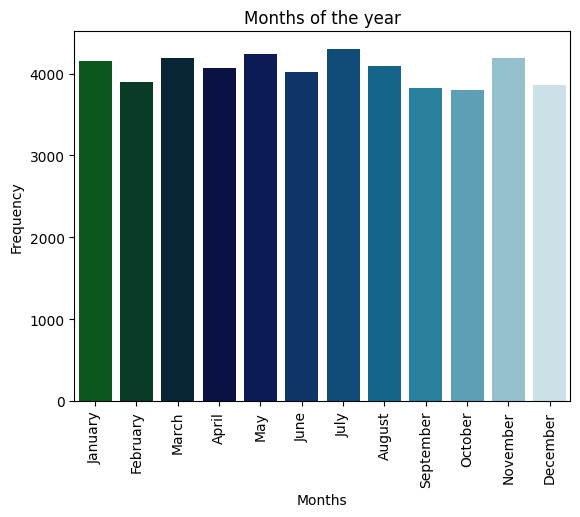

In [15]:
# Months of the year
sns.countplot(data=data,x="order_month",palette="ocean")
plt.xticks(rotation=90)
plt.xlabel("Months",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Months of the year")
plt.show()

In [16]:
data.pizza_id.value_counts()

,count
pizza_id,
big_meat_s,1811
thai_ckn_l,1365
five_cheese_l,1359
four_cheese_l,1273
classic_dlx_m,1159
...,...
mexicana_s,160
calabrese_s,99
ckn_alfredo_s,96


<ipython-input-17-0b536554c38d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x="pizza_id",palette="ocean",ax=ax)


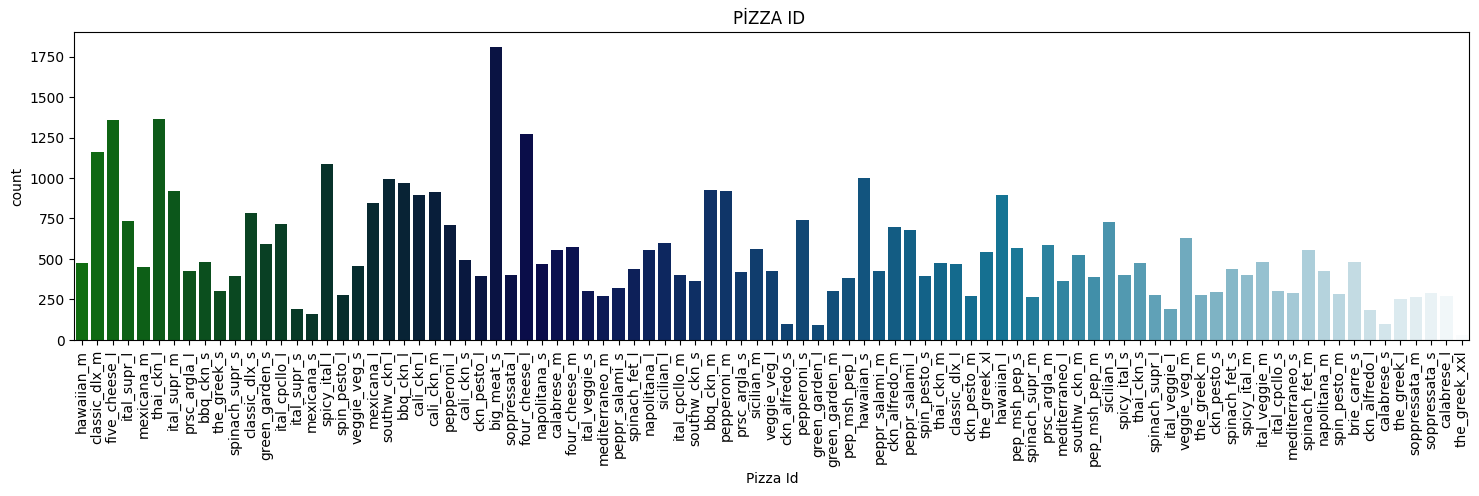

In [17]:
# Pizza ID
fig, ax = plt.subplots(figsize=(18, 4))
sns.countplot(data=data,x="pizza_id",palette="ocean",ax=ax)
plt.xticks(rotation=90)
plt.xlabel("Pizza Id",fontsize=10)
plt.title("PİZZA ID ")
plt.show()

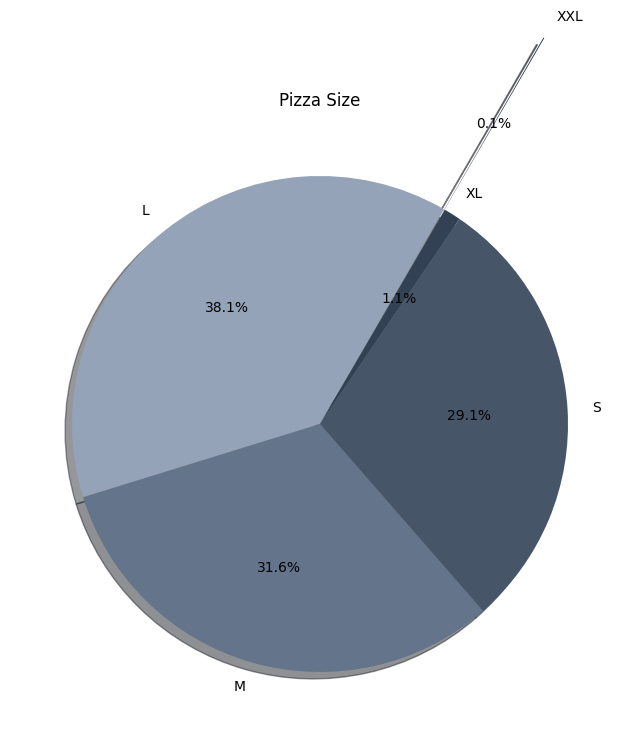

In [18]:
labels = data["pizza_size"].value_counts().index
sizes = data["pizza_size"].value_counts()
plt.figure(figsize = (8,10))

colors = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b","cyan"]
plt.title("Pizza Size")
plt.pie(sizes, labels=labels, rotatelabels=False, autopct='%1.1f%%',colors=colors,shadow=True, startangle=60,explode=(0,0,0,0,0.8))
plt.show()

In [19]:
data.pizza_category.value_counts()

,count
pizza_category,
Classic,14579
Supreme,11777
Veggie,11449
Chicken,10815


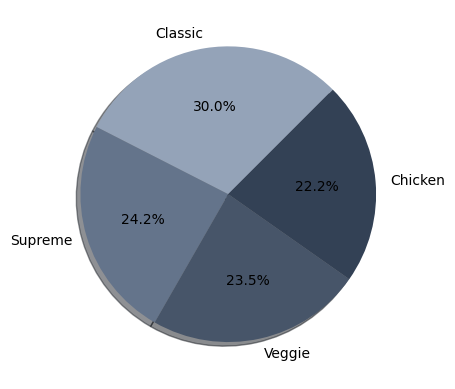

In [20]:
labels = data["pizza_category"].value_counts().index
sizes = data["pizza_category"].value_counts()
colors = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b","cyan"]
plt.pie(sizes, labels=labels, rotatelabels=False, autopct='%1.1f%%',colors=colors,shadow=True, startangle=45)
plt.show()

In [21]:
data.Hour.value_counts()

,count
Hour,
12,6543
13,6203
18,5359
17,5143
19,4350
16,4185
14,3521
20,3487
15,3170


<ipython-input-22-c01c876e6fb9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x="Hour",palette="ocean")


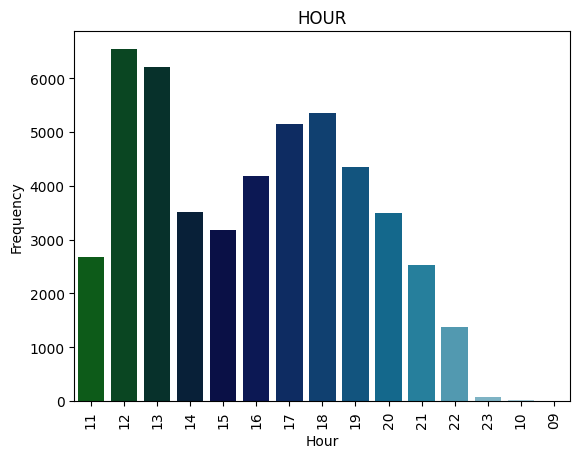

In [22]:
sns.countplot(data=data,x="Hour",palette="ocean")
plt.xticks(rotation=90)
plt.xlabel("Hour",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("HOUR")
plt.show()

In [23]:
data.pizza_ingredients.value_counts()

,count
pizza_ingredients,
"Pepperoni, Mushrooms, Red Onions, Red Peppers, Bacon",2416
"Barbecued Chicken, Red Peppers, Green Peppers, Tomatoes, Red Onions, Barbecue Sauce",2372
"Sliced Ham, Pineapple, Mozzarella Cheese",2370
"Mozzarella Cheese, Pepperoni",2369
"Chicken, Pineapple, Tomatoes, Red Peppers, Thai Sweet Chilli Sauce",2315
"Chicken, Artichoke, Spinach, Garlic, Jalapeno Peppers, Fontina Cheese, Gouda Cheese",2302
"Coarse Sicilian Salami, Tomatoes, Green Olives, Luganega Sausage, Onions, Garlic",1887
"Capocollo, Tomatoes, Goat Cheese, Artichokes, Peperoncini verdi, Garlic",1887
"Chicken, Tomatoes, Red Peppers, Red Onions, Jalapeno Peppers, Corn, Cilantro, Chipotle Sauce",1885


In [24]:
data.pizza_name.value_counts()

,count
pizza_name,
The Classic Deluxe Pizza,2416
The Barbecue Chicken Pizza,2372
The Hawaiian Pizza,2370
The Pepperoni Pizza,2369
The Thai Chicken Pizza,2315
The California Chicken Pizza,2302
The Sicilian Pizza,1887
The Spicy Italian Pizza,1887
The Southwest Chicken Pizza,1885


In [25]:
fig = px.bar(data_frame=data,
             x='order_dates',
             color_discrete_sequence=['#03055B'],
             labels={'order_dates': 'Order Dates', 'value': 'Number of orders'},
             template='plotly_white',
             title='<b>What day are the most orders placed?</b>')

fig.update_layout(
    xaxis_title_text='Order Dates',
    yaxis_title_text='Number of orders',
    font_family='Arial',
    font_size=12,
    title_x=0.5
)

fig.show()

In [26]:
fig = px.box(data,
             x='pizza_name',
             y='total_price',
             color='pizza_name',
             template='seaborn',
             labels={'pizza_name': 'Pizza Name', 'total_price': 'Price'},
             title='<b>Pizza Names and Prices</b>')

fig.update_layout(
    xaxis_title_text='Pizza Name',
    yaxis_title_text='Price',
    font_family='Arial',
    font_size=12,
    title_x=0.5
)

# Show the plot
fig.show()

In [37]:
pizza_size_counts = data.groupby('pizza_size', as_index=False)['total_price'].count().sort_values(by='total_price', ascending=False)

# Create a box plot to visualize pizza prices
fig = px.pie(pizza_size_counts,
             names='pizza_size',
             values='total_price',
             color='pizza_size',
             hole=0.7,
             labels={'pizza_size': 'Pizza Size', 'total_price': 'Count'},
             template='ggplot2',
             title='<b>Pizza Sizes Distribution</b>')

fig.update_layout(
    title_x=0.5,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.0,
        xanchor='right',
        x=0.65
    )
)

# Show the plot
fig.show()

In [28]:
# Count the occurrences of each pizza category
pizza_category_counts = data['pizza_category'].value_counts()

# Create a bar chart to visualize the distribution of pizza categories
fig = px.bar(pizza_category_counts,
             x=pizza_category_counts.index,
             y=pizza_category_counts.values,
             color=pizza_category_counts.index,
             text=pizza_category_counts.values,
             labels={'index': 'Pizza Category', 'y': 'Total Count', 'text': 'Total Count'},
             template='ggplot2',
             title='<b>Total Count of Pizza Categories</b>')

# Show the bar chart
fig.show()

# Create a pie chart to visualize the distribution of pizza categories
fig = px.pie(pizza_category_counts,
             names=pizza_category_counts.index,
             values=pizza_category_counts.values,
             labels={'index': 'Pizza Category', 'y': 'Total Count', 'text': 'Total Count'},
             template='ggplot2')

# Show the pie chart
fig.show()

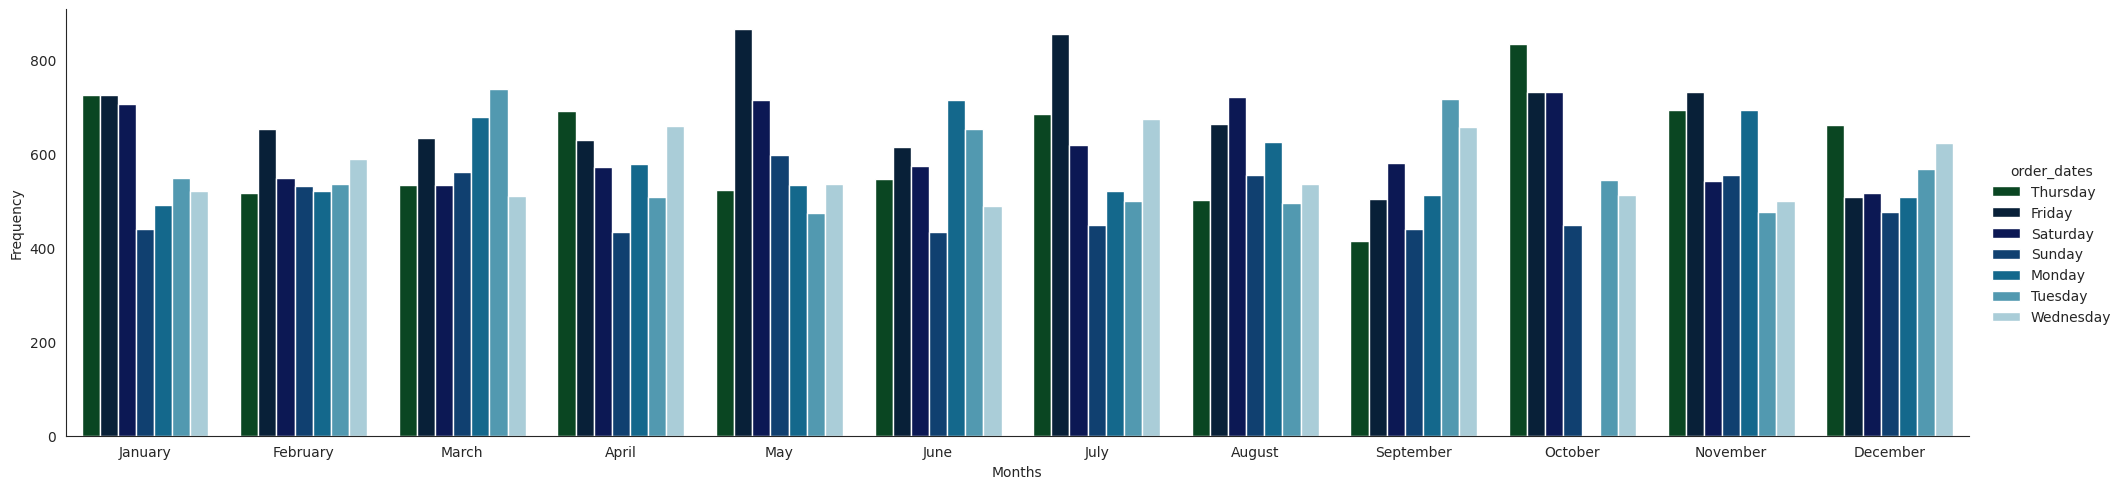

In [29]:
with sns.axes_style('white'):
    # Create a categorical plot to visualize the count of orders by month
    g = sns.catplot(x="order_month",
                     data=data,
                     aspect=4.0,
                     kind='count',
                     hue='order_dates',
                     palette="ocean")

    # Set the y-axis label
    g.set_ylabels('Frequency')

    # Set the x-axis label
    g.set_xlabels("Months")

# Show the plot
plt.show()

In [30]:
# Create a strip plot to visualize the distribution of orders by date and hour
fig = px.strip(data,
               x='order_dates',
               y='Hour',
               color='order_dates')

# Show the plot
fig.show()

In [31]:
# Sort the DataFrame by 'total_price' in descending order
joint_data = data.sort_values(by='total_price', ascending=False)

# Select the top-rated data (in this case, the entire sorted DataFrame)
top_rated = joint_data[:]

# Create a sunburst plot to visualize the total price distribution by pizza category and size
fig = px.sunburst(
    top_rated,
    path=['pizza_category', "pizza_size"],
    values='total_price',
    color='total_price')


fig.update_layout(
    title='<b>Total Price Distribution by Pizza Category and Size</b>',
    font_family='Arial',
    font_size=12,
    title_x=0.5
)

# Show the plot
fig.show()

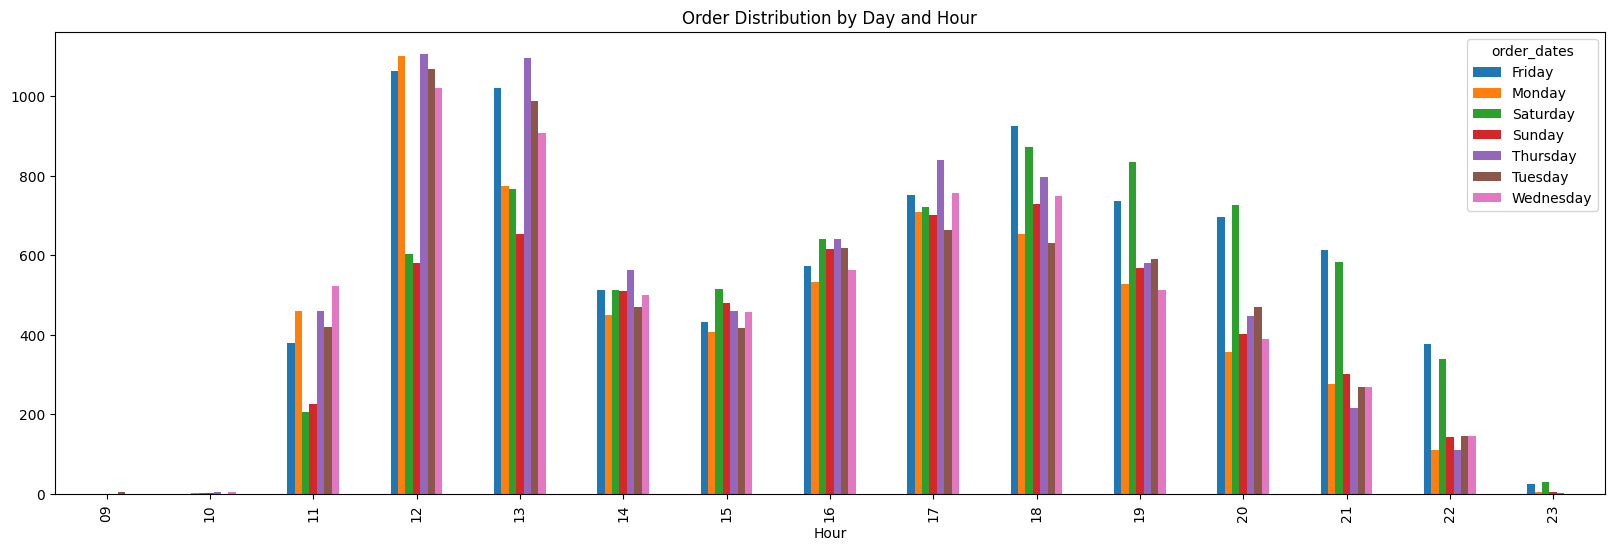

In [32]:
# Create a cross-tabulation of 'Hour' and 'order_dates'
crosstab = pd.crosstab(data["Hour"], data["order_dates"])

# Plot the cross-tabulation as a bar chart
crosstab.plot(kind="bar",
              figsize=(20, 6),
              color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"],
              title="Order Distribution by Day and Hour")

# Show the plot
plt.show()

In [33]:
# Group the DataFrame by 'pizza_size' and 'pizza_category', calculate the median of 'total_price'
df1 = data.groupby(["pizza_size", "pizza_category"], as_index=False)[['total_price']].median().rename(columns={'total_price': 'price'})

# Create a treemap to visualize the median price distribution by pizza size and category
fig = px.treemap(df1,
                 path=[px.Constant("all"), "pizza_size", "pizza_category"],
                 values='price',
                 color='pizza_size',
                 color_discrete_map={'Lunch': '#FFD700', 'Dinner': '#00008B'})

# Update the layout to adjust the margins
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

# Show the plot
fig.show()